# Computer Vision and Convolutional Neural Network

**Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU.

* It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU.

To get the most out of the GPU: [click here](https://horace.io/brrr_intro.html)

* `torchvision` - Base domain library for Pytorch cv
* `torchvision.datasets` - get datasets and data loading functions for cv problems
* `torchvision.models` - get pretrained cv models that can be used for our own problems
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Creates a Python iterable over a datset

In [260]:
# Import Torch
import torch
from torch import nn

# Torch Vision
import torchvision
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor

# Pandas and numpy
import pandas as pd 
import numpy as np

# Timer
from timeit import default_timer as timer

# Visualization
import matplotlib.pyplot as plt
from tqdm import tqdm
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Getting Database (Fashion mnist)

In [261]:
# Training data
train_data = datasets.FashionMNIST(
    root = "../Datasets",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform= None
)

test_data = datasets.FashionMNIST(
    root = "../Datasets",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform= None
)

In [262]:
len(train_data), len(test_data)

(60000, 10000)

In [263]:
image , label = train_data[1]

In [264]:
class_names = train_data.classes
class_no = len (class_names)
class_names, class_no

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 10)

In [265]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [266]:
print(f"Image shape: {image.shape} -> [c , h, w]")

Image shape: torch.Size([1, 28, 28]) -> [c , h, w]


 ## 1.2 Visualizing


Image shape: - torch.Size([1, 28, 28])


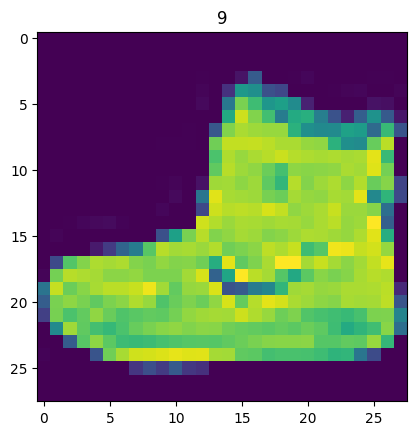

In [267]:
import matplotlib.pyplot as plt

image, label = train_data[0]
print(f"Image shape: - {image.shape}")
plt.imshow(image.squeeze())
plt.title(label);

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

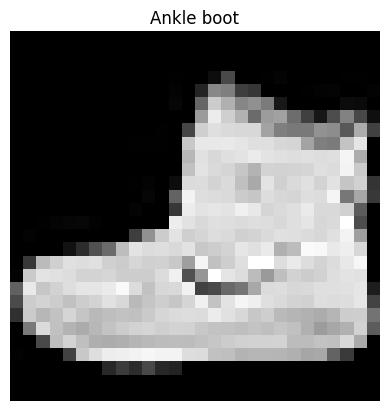

In [268]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

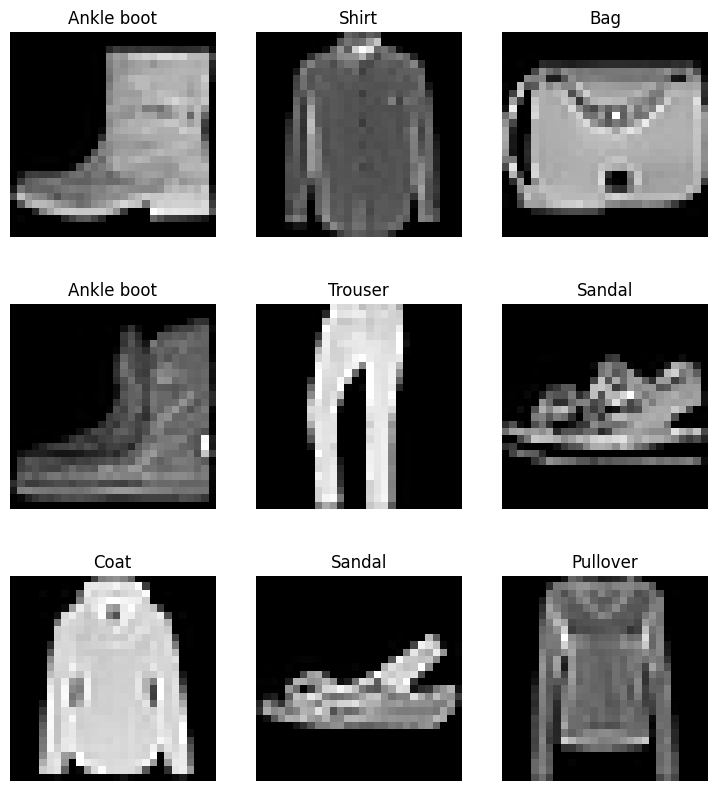

In [269]:
fig,axes = plt.subplots(nrows=3,ncols=3,figsize = (9,10))
axes=axes.flatten()
for i in axes:
    img = torch.randint(0, len(train_data), (1,)).item()
    i.imshow(train_data[img][0].squeeze(),cmap="grey")
    i.set_title(class_names[train_data[img][1]])
    i.axis("off")

In [270]:
import os
print(os.cpu_count())

24


## 2. Prepare DataLoader
Right now the data is in the form of PyTorch Datasets.

DataLoader turns the dataset into a Python iterable

More specifically, we want to turn the data into batchest (or mini-batches).

Why should we do this??

1. It is more computationally efficient as the computer hardware may not be able to look at all the images in one hit hence we break it into small batches
2. it gives our nueral network more chances to update its gradients per epoch

In [271]:
from torch.utils.data import DataLoader
batch_size = 1024
train_dataloader = DataLoader(dataset = train_data,
                              shuffle=True,
                              batch_size=batch_size)

test_dataloader = DataLoader(dataset = test_data,
                              shuffle=False,
                              batch_size=batch_size)

In [272]:
print(f'Length of train_dataLoader: {len(train_dataloader)} batches of {train_dataloader.batch_size}')

Length of train_dataLoader: 59 batches of 1024


In [273]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

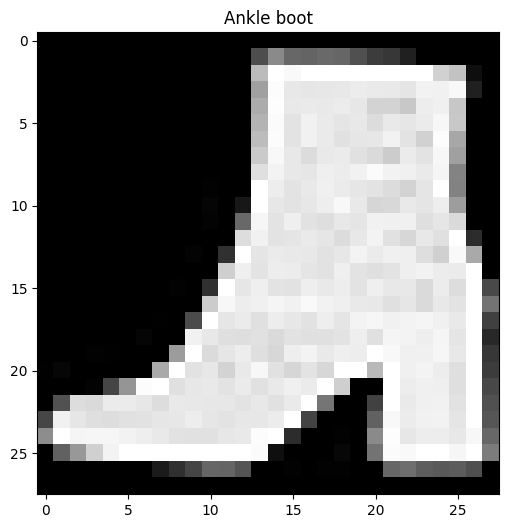

In [274]:
# visualizing a sample from the batch
torch.manual_seed(42)
rand_idx = torch.randint(0,len(train_features_batch),size=(1,)).item()
img = train_features_batch[rand_idx]
plt.figure(figsize=(10,6))
plt.imshow(img.squeeze(), cmap="grey")
plt.title(class_names[train_labels_batch[rand_idx]])
plt.show()

## 3. Model (MLP)

In [275]:
class MLPImage(nn.Module):
    def __init__(self,input_features,hidden_units,output_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )

    def forward(self,X_train):
        return self.layers(X_train)


model_mlp = MLPImage(28*28,32,class_no).to(device)


In [276]:
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=class_no).to(device)

In [277]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_mlp.parameters(),lr=0.001)

### Train and Test Loop

100%|██████████| 3/3 [00:08<00:00,  2.77s/it]


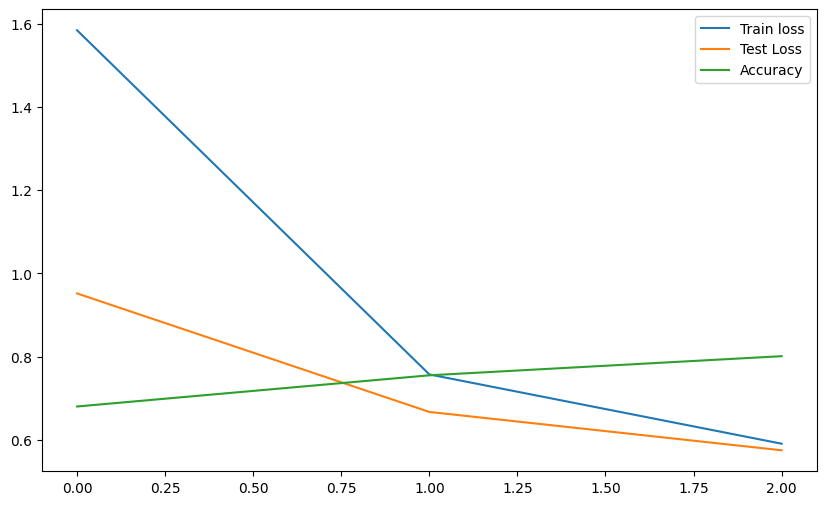

In [278]:
epochs = 3
train_loss = []
test_loss = []
ep = []
Accuracy = []
start = timer()
for epoch in tqdm(range(epochs)):
    ep.append(epoch)
    train_l = 0
    test_L = 0
    acc = 0
    for images,labels in train_dataloader:
        model_mlp.train()
        images, labels = images.to(device), labels.to(device)
        y_pred = model_mlp(images)
        loss = loss_fn(y_pred,labels)
        train_l+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_l = train_l/len(train_dataloader)
    train_loss.append(train_l)

    # Testing
    model_mlp.eval()
    with torch.inference_mode():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            y_pred = model_mlp(images)
            loss = loss_fn(y_pred,labels)
            test_L += loss.item()
            pred_cls = torch.argmax(y_pred, dim=1)
            acc+= acc_fn(pred_cls,labels).item()

        test_L = test_L/len(test_dataloader)
        test_loss.append(test_L)

        acc = acc/len(test_dataloader)
        Accuracy.append(acc)
end = timer()
plt.figure(figsize=(10,6))
plt.plot(ep,train_loss, label = "Train loss")
plt.plot(ep,test_loss,label = "Test Loss")
plt.plot(ep,Accuracy, label = "Accuracy")
plt.legend()
plt.show()

mlp_time = round(end - start,2)  

## Eval function

In [279]:
def eval_model(model,
               dataloader,
               acc_fn,
               loss_fn,
               device = device):
    torch.manual_seed(42)
    loss, acc =0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(dataloader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred,y)
            acc += acc_fn(y_pred.argmax(dim=1),y)

        loss /= len(dataloader)
        acc /= len(dataloader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc.item()*100}

In [280]:
mlp_results = eval_model(model=model_mlp,
                         dataloader=test_dataloader,
                         acc_fn=acc_fn,
                         loss_fn=loss_fn)
mlp_results

100%|██████████| 10/10 [00:00<00:00, 28.05it/s]


{'model_name': 'MLPImage',
 'model_loss': 0.5751706957817078,
 'model_acc': 80.11798858642578}

## Functions for training and testing step

In [281]:
def training_step(model: torch.nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  optimizer: torch.optim.Optimizer,
                  loss_fn: torch.nn.Module,
                  acc_fn,
                  device: torch.device = device):
    """Performs a training step on model over the DataLoader"""

    model.train()
    train_L, train_acc = 0,0

    for X,y in data_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)

        optimizer.zero_grad()

        loss = loss_fn(y_pred,y)
        train_L += loss.item()
        train_acc += acc_fn(y_pred.argmax(dim=1),y)

        loss.backward()
        optimizer.step()
    train_acc /= len(data_loader)
    train_L /= len(data_loader)
    print(f"Training Loss : {train_L}|Training Accuracy: {train_acc*100}%")


def testing_step(model: torch.nn.Module,
                 data_loader: torch.utils.data.DataLoader,
                 loss_fn: torch.nn.Module,
                 acc_fn,
                 device: torch.device = device):
    
    test_L, test_acc =0, 0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            test_L += loss_fn(y_pred,y).item()
            test_acc += acc_fn(y_pred.argmax(dim=1),y)
        
        test_L /= len(data_loader)
        test_acc /= len(data_loader)
    print(f"Testing Loss : {test_L}|Testing Accuracy : {test_acc*100}%")

## 4. CNN Model(tiny vgg)

To get brief idea about whats happening within cnn models [click here](https://poloclub.github.io/cnn-explainer/)

### Conv2D Output Shape Formula

The output spatial dimensions (Height and Width) of a 2D convolution layer are given by:

#### 📐 Output Height:
Output Height = floor((H - K + 2P) / S) + 1

#### 📐 Output Width:
Output Width = floor((W - K + 2P) / S) + 1

Where:
- \( H \) = Input height  
- \( W \) = Input width  
- \( K \) = Kernel size  
- \( P \) = Padding  
- \( S \) = Stride  

### Building model class

In [282]:
class CNN_Model(nn.Module):
    """
    CNN model based on Tiny VGG Architecture
    """
    def __init__(self, in_channels: int, 
                 hidden_channels: int,
                 output_shape: int,
                 height: int,
                 width: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, # Input is the number of colour channels
                      out_channels=hidden_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2)  # default size of stride in maxpool is same as kernel size   
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2)        
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_channels*(height//4)*(width//4),
                      out_features=output_shape)
        )

    def forward(self, X):
        X = self.conv_block_1(X)
        X = self.conv_block_2(X)     
        return self.classifier(X) 

### Experimenting with different hyper paremeter values

In [283]:
image = torch.randn(size=(32,3,64,64))
print(f"shape before passing through layers {image.shape}")
conv = nn.Conv2d(in_channels=3,
                 out_channels=3,
                 kernel_size=3,
                 stride=1,
                 padding=1)
image = conv(image)
print(f"shape after conv layer {image.shape}")

maxpool = nn.MaxPool2d(kernel_size=4)
image = maxpool(image)
print(f"shape after passing through max pool {image.shape}")

shape before passing through layers torch.Size([32, 3, 64, 64])
shape after conv layer torch.Size([32, 3, 64, 64])
shape after passing through max pool torch.Size([32, 3, 16, 16])


### Train Test Loop

In [284]:
torch.manual_seed(42)
model_vgg = CNN_Model(in_channels=1,
                      hidden_channels=10,
                      output_shape= len(class_names),
                      height=28,
                      width=28).to(device)

In [285]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_vgg.parameters(),lr=0.01)

In [286]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 3
start = timer()
for epoch in range(epochs):    
    training_step(model=model_vgg,
                  data_loader=train_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  acc_fn=acc_fn)
    testing_step(model=model_vgg,
                data_loader=test_dataloader,
                loss_fn=loss_fn,
                acc_fn=acc_fn)   
end = timer()
vgg_time = round(end - start,2)  


Training Loss : 0.9444961972155813|Training Accuracy: 65.87519073486328%
Testing Loss : 0.5686326563358307|Testing Accuracy : 79.50653076171875%
Training Loss : 0.4612669404280388|Training Accuracy: 83.27063751220703%
Testing Loss : 0.41984873414039614|Testing Accuracy : 85.07693481445312%
Training Loss : 0.3843534917144452|Training Accuracy: 86.10397338867188%
Testing Loss : 0.3906768441200256|Testing Accuracy : 85.77766418457031%


In [287]:
vgg_results = eval_model(model = model_vgg,
                         dataloader = test_dataloader,
                         acc_fn =acc_fn,
                         loss_fn = loss_fn)

100%|██████████| 10/10 [00:00<00:00, 27.63it/s]


## 5. Model Comparision

In [288]:
vgg_results,mlp_results

({'model_name': 'CNN_Model',
  'model_loss': 0.3906768262386322,
  'model_acc': 85.77766418457031},
 {'model_name': 'MLPImage',
  'model_loss': 0.5751706957817078,
  'model_acc': 80.11798858642578})

In [289]:
vgg_time, mlp_time

(8.67, 8.3)

In [290]:
model_comp = pd.DataFrame([mlp_results,vgg_results])
model_comp["Time Taken"] = [mlp_time, vgg_time]
model_comp

,model_name,model_loss,model_acc,Time Taken
0,MLPImage,0.575171,80.117989,8.30
1,CNN_Model,0.390677,85.777664,8.67


(Text(0.5, 0, 'Model'), Text(0, 0.5, 'Accuracy'))

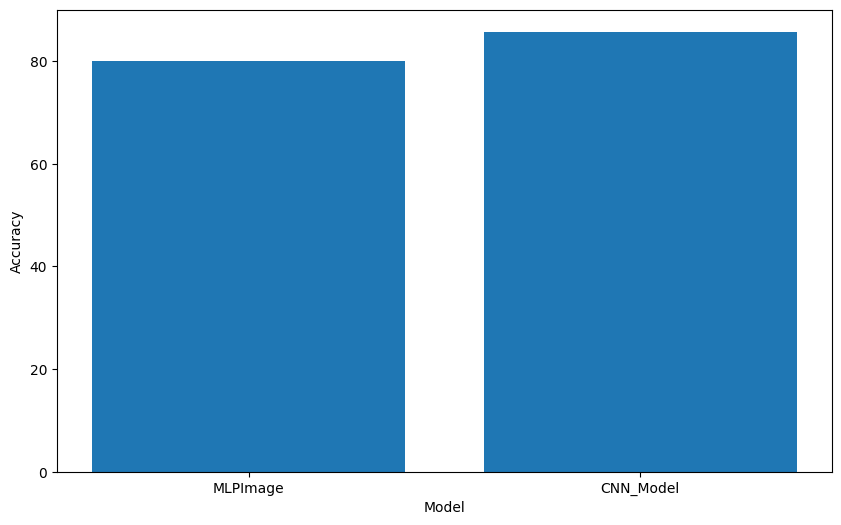

In [291]:
plt.figure(figsize = (10,6))
plt.bar(model_comp["model_name"],model_comp["model_acc"])
plt.xlabel("Model"), plt.ylabel("Accuracy")


## 6. Random Predictions

In [332]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device,
                     class_names = class_names):
    pred_cls = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample,dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
            pred_cls.append(class_names[pred_prob.argmax()])

    return pred_cls

In [339]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample,label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [ ]:
pred_cls = make_predictions(model= model_vgg,
                            data=test_samples)

<Figure size 1500x1500 with 0 Axes>

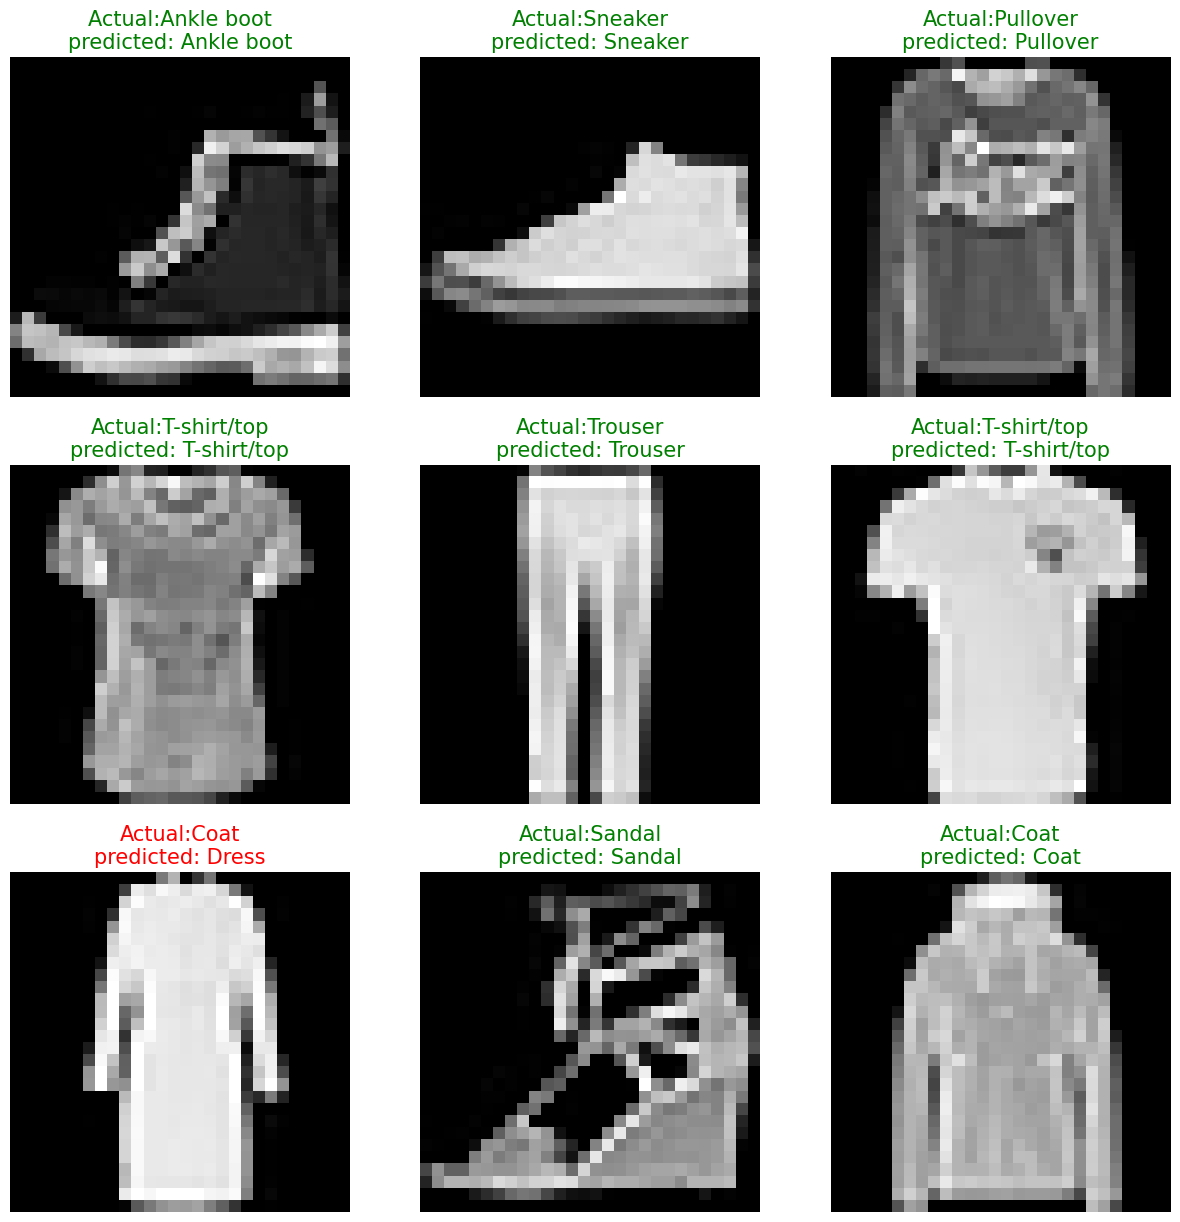

In [341]:
plt.figure(figsize=(15,15))
fig,axes = plt.subplots(ncols=3, nrows=3,figsize = (15,15))
axes = axes.flatten()
for i,ax in enumerate(axes):
    ax.imshow(test_samples[i].squeeze(),cmap = 'grey')
    if class_names[test_labels[i]] == pred_cls[i]:
        ax.set_title(f"Actual:{class_names[test_labels[i]]}\npredicted: {pred_cls[i]}",fontsize = 15, c="g")
    else:
        ax.set_title(f"Actual:{class_names[test_labels[i]]}\npredicted: {pred_cls[i]}",fontsize = 15, c="r")
    ax.axis("off")

## Confusion matrix

<Figure size 1000x800 with 0 Axes>

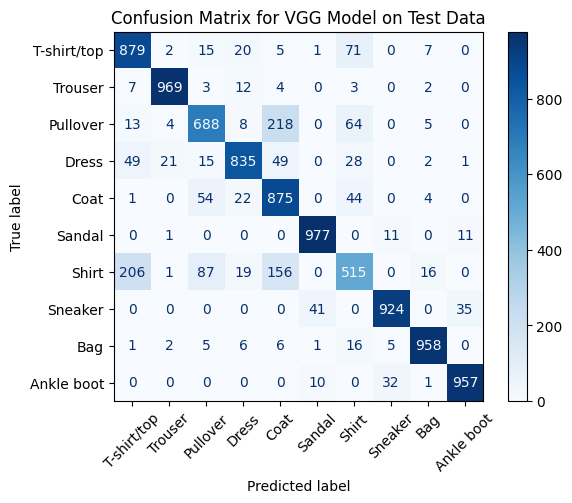

In [344]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []
model_vgg.eval()
with torch.inference_mode():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10,8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for VGG Model on Test Data")
plt.show()

## Saving the model

In [345]:
Model_save_path = "../models/Tiny_VGG_FashionMNIST.pth"
print(f"Saving the model to path:{Model_save_path}")
torch.save(model_vgg.state_dict(),Model_save_path)

Saving the model to path:../models/Tiny_VGG_FashionMNIST.pth
